# Linear Regression Training Notebook

This notebook trains a linear regression model to predict the **Bitcoin price** based on Fear & Greed Index data. It includes automated model versioning for managing challenger and champion models.

## Imports 

In [1]:
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('./src')
from model_io import save_model


## Load and Prepare Data
Read the processed Parquet data, sort by time, and prepare features and targets for model training.

In [2]:
data_path = '../data/processed/fear_and_greed_history_5min.parquet'
df = pl.read_parquet(data_path).sort('interval_end_time')

# Check for NaN values in the dataset
print("Checking for missing values:")
print(f"Total rows: {len(df)}")
print(f"Missing values in avg_actual_value: {df['avg_actual_value'].is_null().sum()}")
print(f"Missing values in close_bitcoin_price_usd: {df['close_bitcoin_price_usd'].is_null().sum()}")

# Remove rows with NaN values before training
df_clean = df.drop_nulls(['avg_actual_value', 'close_bitcoin_price_usd'])
print(f"Rows after removing NaN values: {len(df_clean)}")

# Prepare data for training
# Feature: Fear & Greed Index, Target: BTC price
X = df_clean.select('avg_actual_value').to_numpy()  # Fear & Greed Index
y = df_clean.select('close_bitcoin_price_usd').to_numpy().flatten()  # BTC price

print(f"Final data shape - X: {X.shape}, y: {y.shape}")

# Train-test split (80%-20% split)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Additional check for NaN values in train/test splits
print(f"NaN values in X_train: {sum(~np.isfinite(X_train.flatten()))}")
print(f"NaN values in X_test: {sum(~np.isfinite(X_test.flatten()))}")
print(f"NaN values in y_train: {sum(~np.isfinite(y_train))}")
print(f"NaN values in y_test: {sum(~np.isfinite(y_test))}")


Checking for missing values:
Total rows: 36342
Missing values in avg_actual_value: 0
Missing values in close_bitcoin_price_usd: 68
Rows after removing NaN values: 36274
Final data shape - X: (36274, 1), y: (36274,)
NaN values in X_train: 0
NaN values in X_test: 0
NaN values in y_train: 0
NaN values in y_test: 0


## Train and Evaluate Model
Train a linear regression model on the training data and evaluate its performance on the test set.

In [3]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)

# Clean predictions and test data to remove any NaN values before evaluation
mask = ~np.isnan(y_test) & ~np.isnan(y_pred)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

print(f"Cleaned data for evaluation: {len(y_test_clean)} samples (removed {len(y_test) - len(y_test_clean)} NaN values)")

mse = mean_squared_error(y_test_clean, y_pred_clean)
print(f'Mean Squared Error: {mse:.4f}')

# Debug: Print training data statistics
print(f"\nTraining Data Statistics:")
print(f"X_train (Fear & Greed Index) - Min: {X_train.min():.2f}, Max: {X_train.max():.2f}, Mean: {X_train.mean():.2f}")
print(f"y_train (BTC Price) - Min: ${y_train.min():.2f}, Max: ${y_train.max():.2f}, Mean: ${y_train.mean():.2f}")
print(f"Model intercept: {model.intercept_}")
print(f"Model coefficient: {model.coef_[0]}")

# Check prediction sanity
sample_prediction = model.predict([[50]])  # Predict for Fear & Greed Index = 50
print(f"\nSanity Check - Prediction for Fear & Greed Index = 50: ${sample_prediction[0]:.2f}")
if sample_prediction[0] < 0:
    print("⚠️  WARNING: Model predicts negative Bitcoin price! This indicates a training issue.")


Cleaned data for evaluation: 7255 samples (removed 0 NaN values)
Mean Squared Error: 28563733.8667

Training Data Statistics:
X_train (Fear & Greed Index) - Min: 38.86, Max: 74.87, Mean: 62.11
y_train (BTC Price) - Min: $98476.00, Max: $124200.00, Mean: $113591.31
Model intercept: 94196.91447716141
Model coefficient: 312.2532745535822

Sanity Check - Prediction for Fear & Greed Index = 50: $109809.58


## Model Versioning and Saving
Save the trained model weights and metadata, and manage champion/challenger logic for model versioning.

In [4]:
# Prepare weights DataFrame
weights_df = pl.DataFrame({
    'feature': ['intercept', 'avg_actual_value'],  # Fixed: use actual column name from training data
    'weight': [model.intercept_, model.coef_[0]]
})

# Use the utility function to save the model and handle versioning
result_msg = save_model(weights_df, mse, '../models')
print(result_msg)

# Debug: Print the model weights to verify
print(f"\nModel weights:")
print(f"Intercept: {model.intercept_}")
print(f"Coefficient for avg_actual_value: {model.coef_[0]}")
print(f"Expected BTC price range: ${y.min():.2f} to ${y.max():.2f}")
print(f"Fear & Greed Index range: {X.min():.2f} to {X.max():.2f}")


Challenger model saved (not champion).

Model weights:
Intercept: 94196.91447716141
Coefficient for avg_actual_value: 312.2532745535822
Expected BTC price range: $98476.00 to $126157.00
Fear & Greed Index range: 38.86 to 74.87


## Visualize Data and Model Predictions
Visualize the relationship between Bitcoin price and the Fear & Greed Index, and compare actual vs. predicted values after training.

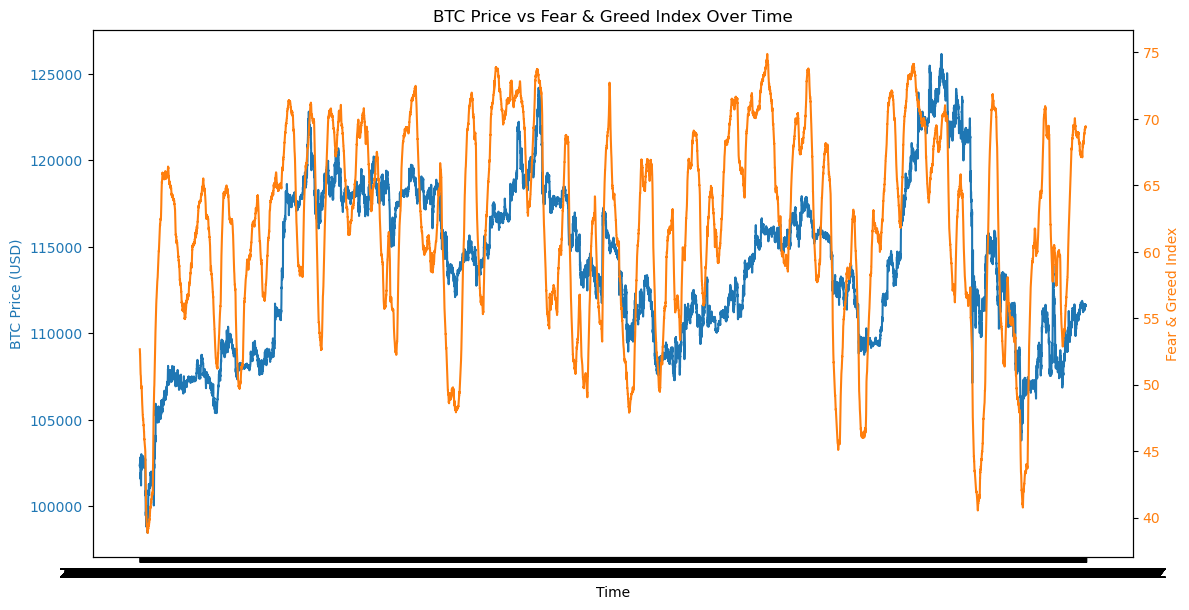

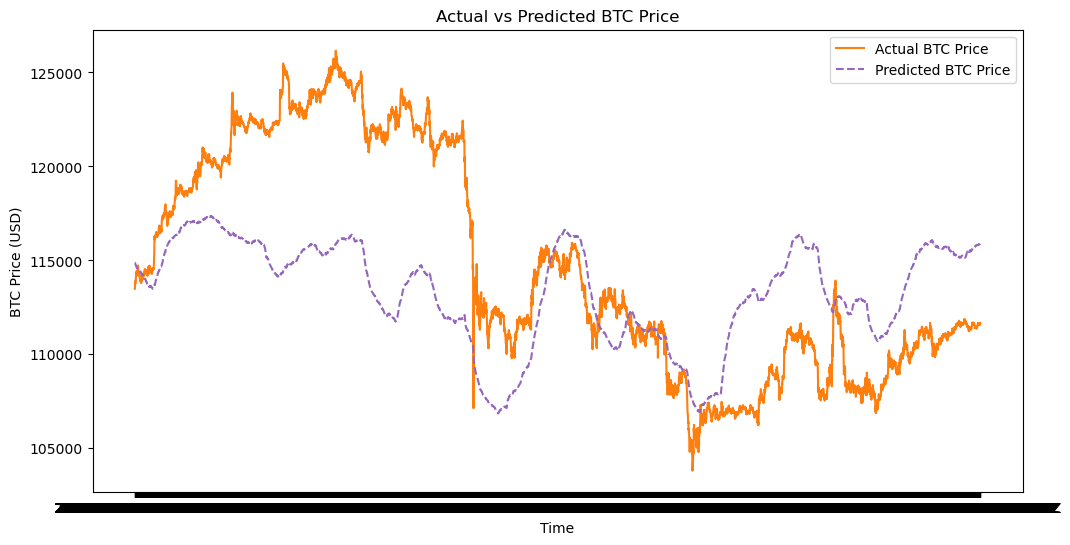

In [5]:
import matplotlib.pyplot as plt

def plot_btc_vs_fear_greed(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('BTC Price (USD)', color=color)
    ax1.plot(df['interval_end_time'].to_numpy(), df['close_bitcoin_price_usd'].to_numpy(), color=color, label='BTC Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Fear & Greed Index', color=color)
    ax2.plot(df['interval_end_time'].to_numpy(), df['avg_actual_value'].to_numpy(), color=color, label='Fear & Greed Index')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('BTC Price vs Fear & Greed Index Over Time')
    plt.show()

# Visualize the cleaned data before training
plot_btc_vs_fear_greed(df_clean)

# After training, plot actual vs predicted BTC price using cleaned data
plt.figure(figsize=(12, 6))
plt.plot(df_clean['interval_end_time'].to_numpy()[split_idx:], y_test_clean, label='Actual BTC Price', color='tab:orange')
plt.plot(df_clean['interval_end_time'].to_numpy()[split_idx:], y_pred_clean, label='Predicted BTC Price', color='tab:purple', linestyle='--')
plt.xlabel('Time')
plt.ylabel('BTC Price (USD)')
plt.title('Actual vs Predicted BTC Price')
plt.legend()
plt.show()
